# HHL in qiskit

Based on [qiskit tutorial](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html).

---

Let's solve a system of linear equations $Ax=b$ in Qiskit. This is easy (joke)!

After we considered the method on the whiteboard, you should know, that the method consists of 4 quantum blocks:

1. $|b\rangle$ initialization, 
2. $QPE$ of $\tilde{A}=e^{iAt}$, 
3. eigenphase inversion, 
4. and uncomputing with $QPE^\dagger$.

Equation:
[[ 1.   -0.33]	[x_0]     ---    [[1]
 [-0.33  1.  ]]	[x_1]     ---     [0]]

LA Solution
[[1.125]
 [0.375]]


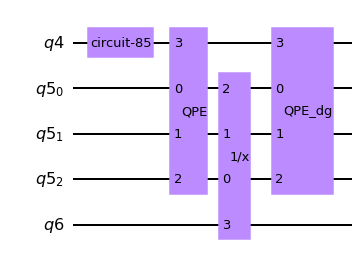

In [1]:
import numpy as np

# algorithm
from qiskit.algorithms.linear_solvers.hhl import HHL

# Matrix A
A = np.array([[1, -1/3], [-1/3, 1]])

# vector b
b = np.array([[1, 0]]).T

axb = "\n".join([
            f"{aa}\t[x_{i}]     ---    {bb}" 
            for i, aa, bb in 
            zip(
                [0, 1],
                str(np.round_(A, 2)).split('\n'), 
                str(b).split('\n')
            )
])
print("Equation:")
print(axb)

print("\nLA Solution")
print(np.linalg.inv(A) @ b)

naive_hhl_solution = HHL().solve(A, b)
# print(type(naive_hhl_solution.state))
naive_hhl_solution.state.draw('mpl')

Pay attention to what is inside "1/x" gate.

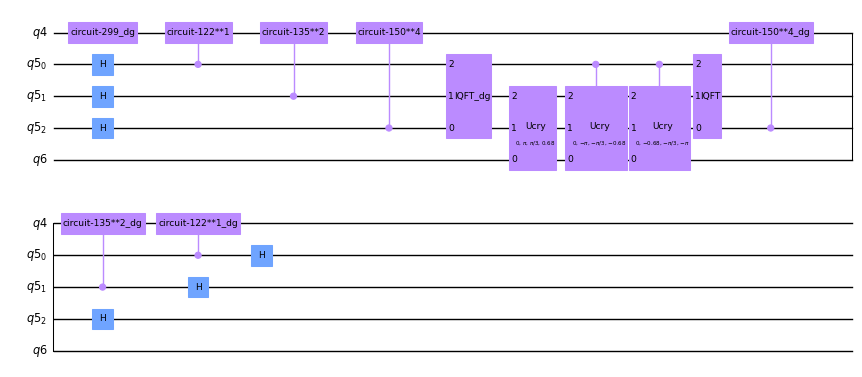

In [2]:
naive_hhl_solution.state.decompose().decompose().draw(output='mpl', scale=.7)

State vector of the whole system. What do we see in this vector? We observe non-zero amplitudes for states $|00000\rangle$, $|00001\rangle$, $|10000\rangle$, and $|10001\rangle$. Thus, only soluition qubit and "decision" qubits are in the superposed states.

In [3]:
from qiskit.quantum_info import Statevector
complete_statevector = Statevector(naive_hhl_solution.state).data
sv = np.round_(complete_statevector, 2)
print(sv[:len(sv)//2])
print()
print(sv[len(sv)//2:])

[ 0.43+0.j -0.43-0.j  0.  +0.j -0.  +0.j  0.  +0.j -0.  +0.j  0.  -0.j
  0.  -0.j  0.  -0.j  0.  +0.j  0.  -0.j -0.  -0.j  0.  -0.j -0.  -0.j
 -0.  +0.j -0.  +0.j]
[ 0.75+0.j  0.25-0.j  0.  -0.j  0.  -0.j  0.  -0.j  0.  -0.j  0.  -0.j
  0.  +0.j  0.  -0.j  0.  -0.j  0.  -0.j -0.  +0.j  0.  -0.j -0.  +0.j
 -0.  -0.j -0.  +0.j]


Extract the "right subvectorvector" components.

`0b1****` corresponds to the index 16+, which means, that 0th qubit was measured as `1`.

`0b*000*` -- zeros in the middle of the state mean auxillary qubits were returned to 0 by uncomputing.

Thus, your solution is hidden in `0b1000*` vector positions.


In [4]:
# Obtain the answer from the full vector
# 1. Get the subvector of your interest
naive_full_vector = # TODO

# 2. Get rid of conditional probability. Norm the amplitudes
x_normed = naive_full_vector
x_normed = # TODO

# 3. re-apply the norming factor to restore the vector we search for
x = x_normed * naive_hhl_solution.euclidean_norm
print(x)

[1.125+0.j 0.375+0.j]


In [5]:
np.allclose(A @ x.reshape(2, 1), b)

True

## Experiment?

Here we re-compose the circuit. Add missing measurements.

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram

qb = QuantumRegister(1, name="b")
qA = QuantumRegister(3, name="matrix")   # in the older version of qiskit in was enough to have 2 qubits for mx
qaux = QuantumRegister(1, name='aux')
cflag = ClassicalRegister(1, name='flag')
cres = ClassicalRegister(1, name='x')
qc = QuantumCircuit(qb, qA, qaux, cflag, cres)

hhl = HHL().solve(A, b)
hhl.state
qc.compose(naive_hhl_solution.state, qb[:] + qA[:] + qaux[:], inplace=True)
qc.barrier()

# TODO!

qc.draw()

There are some shots, but not all of them will be used for solution! 

Why?

In [7]:
shots = 65535
job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)

We will remove all shots which led to `0` in flag qubit.

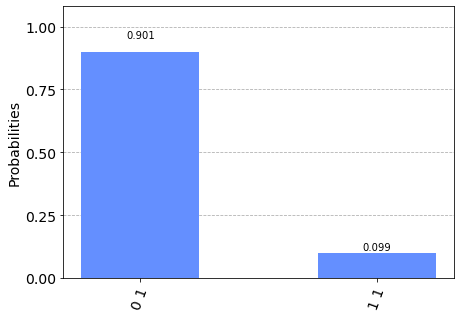

In [8]:
flag_is_0 = ' 0'
del counts['0' + flag_is_0]
del counts['1' + flag_is_0]
plot_histogram(counts)

**TODO**. 
- You measured shots. Shots divided by `total` is probability. But you need amplitudes.
- Reuse `euclidean_norm` to scale your soultion.

In [9]:
total = counts['0 1'] + counts['1 1']
print(total)

# 1. restore the probabilities
p0 = ...
p1 = ...

# 2. Restore amplitudes
a0 = ...
a1 = ...

# 3. Reapply hhl.euclidean_norm
x = np.array([a0, a1])     # TODO
print(x)

40799
[1.12535075 0.3739461 ]
